In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
allStateData = pd.read_csv("us-states.csv")
#California
stateName = "Washington"
eachStateData = allStateData[allStateData["state"]==stateName]
z = eachStateData['deaths']
orig = z.copy()
orig[1:] = np.diff(z)
eachStateData['ActualDeaths'] = orig

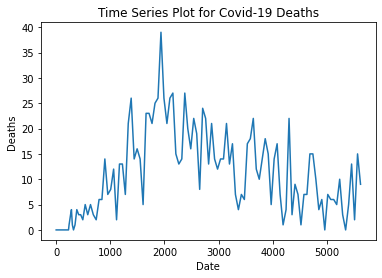

In [4]:
from matplotlib import pyplot
pyplot.title("Time Series Plot for Covid-19 Deaths")
pyplot.xlabel("Date")
pyplot.ylabel("Deaths")
eachStateData["ActualDeaths"].plot()
pyplot.show()

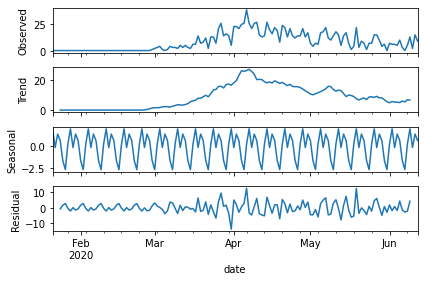

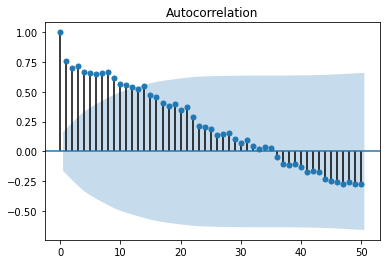

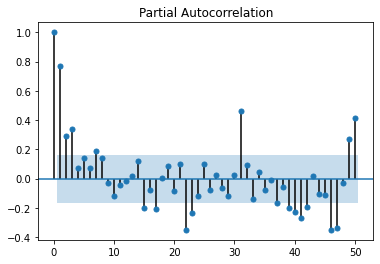

In [6]:
series = eachStateData['ActualDeaths']
series.index = pd.to_datetime(eachStateData['date'])
result = seasonal_decompose(series, model='additive')
result.plot()
# series.plot()
plot_acf(series, lags = 50)
plot_pacf(series, lags = 50)
pyplot.show()

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# load the dataset
dataframe = eachStateData["ActualDeaths"]
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.reshape(-1, 1)
# dataset = scaler.fit_transform(dataset)

In [0]:
# # fix random seed for reproducibility
np.random.seed(5)

In [11]:
# split into train and test sets
look_back=[1,7]
model_list = []
validation_loss = []
trainX_list = []
testX_list = []
trainY_list = []
testY_list = []
for look in look_back:
  train_size =  int(len(dataset) * 0.80)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size-look:train_size + test_size,:]
  # reshape into X=t and Y=t+1
  trainX, trainY = create_dataset(train, look)
  testX, testY = create_dataset(test, look)
  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  trainX_list.append(trainX)
  testX_list.append(testX)
  trainY_list.append(trainY)
  testY_list.append(testY)
  model = Sequential()
  model.add(LSTM(50, input_shape=(look, 1), activation='relu', return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(30, activation='relu', return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(30, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')  
  train_history = model.fit(trainX, trainY, epochs=20, verbose=0, batch_size=5, validation_data=(testX, testY))
  print(train_history.history['val_loss'][-1])
  validation_loss.append(train_history.history['val_loss'][-1])
  model_list.append(model)

48.192409712692786
36.85221356359021


In [0]:
minIndex = validation_loss.index(min(validation_loss))
model_to_use = model_list[minIndex]

In [0]:
trainX = trainX_list[minIndex]
testX = testX_list[minIndex]
trainY = trainY_list[minIndex]
testY = testY_list[minIndex]

In [0]:
# make predictions
trainPredict = model_to_use.predict(trainX)
testPredict = model_to_use.predict(testX)

In [0]:
# predictions for 30 days
tx = trainX
preds = []
for i in range(59):
  tp = model_to_use.predict(tx)
  yhat = tp[i,0]
  preds.append(yhat)
  np.append(tx, yhat)
final_preds = preds[30:]
final_preds

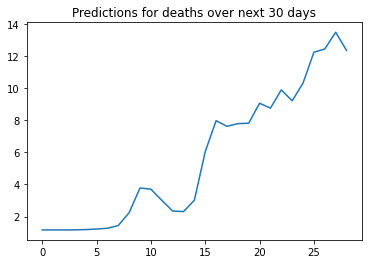

In [67]:
final_preds = preds[30:]
pyplot.title("Predictions for deaths over next 30 days")
pyplot.plot(final_preds)

In [0]:
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

# print(trainY, trainPredict)

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.35 RMSE
Test Score: 6.90 RMSE


In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  print(y_true, y_pred) 
  # y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# calculate root mean squared error
trainScore = math.sqrt(mean_absolute_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f MAP' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY, testPredict[:,0]))
print('Test Score: %.2f MAP' % (testScore))

Train Score: 2.03 MAP
Test Score: 2.33 MAP


In [0]:
testPredict[:,0]

array([ 9.71382  , 11.587459 ,  4.2193265,  1.0025007,  2.1066866,
       14.169557 ,  1.6223837,  5.8899074,  4.2193265,  1.0025007,
        4.2193265,  4.2193265, 10.371665 , 10.371665 ,  6.717864 ,
        2.1066866,  3.4296253,  0.8248738,  4.2193265,  3.4296253,
        3.4296253,  2.7149365,  6.717864 ,  1.6223837,  0.8248738,
        2.7149365,  9.019705 ,  1.2602044, 10.371665 ], dtype=float32)

In [0]:
testY

array([17.,  7.,  1.,  4., 22.,  3.,  9.,  7.,  1.,  7.,  7., 15., 15.,
       10.,  4.,  6.,  0.,  7.,  6.,  6.,  5., 10.,  3.,  0.,  5., 13.,
        2., 15.,  9.], dtype=float32)

In [0]:
# !pip install pmdarima

115 29 144
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=874.640, BIC=886.492, Time=0.084 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=918.842, BIC=924.768, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=899.273, BIC=908.161, Time=0.040 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=873.894, BIC=882.782, Time=0.043 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=916.858, BIC=919.821, Time=0.012 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=874.196, BIC=886.047, Time=0.107 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=873.213, BIC=888.027, Time=0.159 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=874.927, BIC=892.704, Time=0.189 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=874.970, BIC=892.747, Time=0.181 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=874.157, BIC=888.971, Time=0.123 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; 

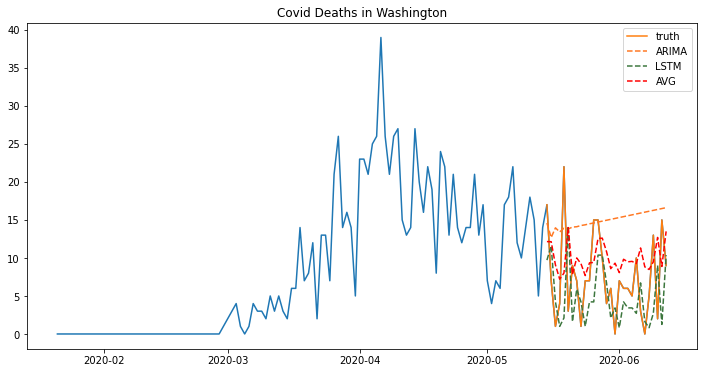

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")



allStateData = pd.read_csv("us-states.csv")
#California
eachStateData = allStateData[allStateData["state"]==stateName]
z = eachStateData['deaths']
orig = z.copy()
orig[1:] = np.diff(z)
eachStateData['ActualDeaths'] = orig

series = eachStateData['ActualDeaths']
series.index = pd.to_datetime(eachStateData['date'])
result = seasonal_decompose(series, model='additive')
# result.plot()
# series.plot()
# plot_acf(series, lags = 50)
# plot_pacf(series, lags = 50)
# pyplot.show()

# load the dataset
dataframe = eachStateData["ActualDeaths"]
dataset = dataframe.values

dateDataFrame =  eachStateData["date"]
dateDataSet = dateDataFrame.values

dataset = dataset.astype('double')

# dataset = dataset.reshape(-1, 1)
# dateDataSet = dateDataSet.reshape(-1, 1)

train_size =  int(len(dataframe) * 0.80)
test_size = len(dataframe) - train_size
print(train_size, test_size,len(dataframe))
train, test = dataset[0:train_size], dataset[train_size:]
train_date, test_date = dateDataSet[0:train_size], dateDataSet[train_size:]

train_series = pd.DataFrame(train, index = pd.to_datetime(train_date), columns = ['deaths'])
test_series = pd.DataFrame(test, index = pd.to_datetime(test_date), columns= ['deaths'])


# model = ExponentialSmoothing(train_series, trend="add", seasonal="add")
# model2 = ExponentialSmoothing(train_series, trend="add", seasonal="add", damped=True)
# fit = model.fit()
# pred = fit.forecast(test_size)
# fit2 = model2.fit()
# pred2 = fit2.forecast(test_size)


# sse1 = np.sqrt(np.mean(np.square(test_series["deaths"].values - pred)))
# sse2 = np.sqrt(np.mean(np.square(test_series["deaths"].values - pred2)))


stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=6, max_q=6,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
stepwise_model.fit(train_series)
future_forecast = stepwise_model.predict(n_periods=test_size)
# print(future_forecast, test_series["cases"].values)

testScore = math.sqrt(mean_absolute_error(future_forecast, test_series["deaths"].values))
print('Test Score using ARIMA: %.2f MAP' % (testScore))
testScore = math.sqrt(mean_squared_error(future_forecast, test_series["deaths"].values))
print('Test Score using ARIMA: %.2f RMSE' % (testScore))
testScore = math.sqrt(mean_absolute_error(testY, testPredict[:,0]))
print('Test Score using LSTM: %.2f MAP' % (testScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score using LSTM: %.2f RMSE' % (testScore))

tups = [future_forecast, testPredict[:,0]]
new_forecast = [sum(x)/len(x) for x in zip(*tups)]
# print(sse1, sse2)
testScore = math.sqrt(mean_absolute_error(testY, new_forecast))
print('Test Score using Average model: %.2f MAP' % (testScore))
testScore = math.sqrt(mean_squared_error(testY, new_forecast))
print('Test Score using Average model: %.2f RMSE' % (testScore))


pred_Series = pd.DataFrame(future_forecast, index = pd.to_datetime(test_date), columns= ['deaths'])
pred_lstm = pd.DataFrame(testPredict[:,0],index = pd.to_datetime(test_date), columns= ['deaths'])
pred_avg = pd.DataFrame(new_forecast,index = pd.to_datetime(test_date), columns= ['deaths'])
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(train_series.index, train_series.values);
ax.plot(series.index, series.values);
ax.plot(test_series.index, test_series.values, label='truth');
ax.plot(pred_Series.index, pred_Series.values, linestyle='--', color='#ff7823', label="ARIMA");
ax.plot(test_series.index, pred_lstm.values, linestyle='--', color='#3c763d', label="LSTM");
ax.plot(test_series.index, pred_avg.values, linestyle='--', color='red', label="AVG");  
ax.legend();
ax.set_title("Covid Deaths in "+ stateName);
plt.show()